# Ookla Connectivity Data Extractor
**Interactive workflow for downloading and preparing Ookla connectivity data**

This notebook provides an interactive interface for:
1. ✅ Verifying source code modules
2. 🌍 Loading geographic boundaries
3. 📥 Downloading Ookla connectivity data
4. 📊 Preparing data for Tableau visualization

---

## Quick Start Guide

1. **Run all cells in order** - Each section builds on the previous
2. **Customize the configuration** - Select your region, year, and data type
3. **Download data** - Execute the download cell to fetch Ookla data
4. **Prepare for Tableau** - Generate optimized Excel files

---

## 📦 Step 1: Environment Setup

Verify that all required modules are available and up-to-date.

In [9]:
import sys
from pathlib import Path
import importlib

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Import all required modules
print("Importing modules...")
print("="*70)

try:
    import pandas as pd
    print("✅ pandas")
except ImportError:
    print("❌ pandas - Run: pip install pandas")

try:
    import geopandas as gpd
    print("✅ geopandas")
except ImportError:
    print("❌ geopandas - Run: pip install geopandas")

try:
    import matplotlib.pyplot as plt
    print("✅ matplotlib")
except ImportError:
    print("❌ matplotlib - Run: pip install matplotlib")

# Import and reload modules to get latest changes
try:
    import src.config as config_module
    importlib.reload(config_module)
    from src.config import list_available_regions, OOKLA_DIR, OUTPUT_DIR
    print("✅ src.config (reloaded)")
except ImportError as e:
    print(f"❌ src.config - {e}")

try:
    import src.data_loader as data_loader_module
    importlib.reload(data_loader_module)
    from src.data_loader import NaturalEarthLoader
    print("✅ src.data_loader (reloaded)")
except ImportError as e:
    print(f"❌ src.data_loader - {e}")

try:
    import src.download_ookla as download_ookla_module
    importlib.reload(download_ookla_module)
    from src.download_ookla import OoklaDownloader
    print("✅ src.download_ookla (reloaded)")
except ImportError as e:
    print(f"❌ src.download_ookla - {e}")

try:
    import src.prepare_tableau as prepare_tableau_module
    importlib.reload(prepare_tableau_module)
    from src.prepare_tableau import TableauDataPreparer
    print("✅ src.prepare_tableau (reloaded)")
except ImportError as e:
    print(f"❌ src.prepare_tableau - {e}")

print("="*70)
print("\n✅ All modules loaded successfully!")
print(f"📁 Project root: {project_root}")
print(f"📁 Data directory: {OOKLA_DIR}")
print(f"📁 Output directory: {OUTPUT_DIR}")
print("\n💡 Tip: All modules are reloaded to reflect latest changes in source files")

Importing modules...
✅ pandas
✅ geopandas
✅ matplotlib
✅ src.config (reloaded)
✅ src.data_loader (reloaded)
✅ src.download_ookla (reloaded)
✅ src.prepare_tableau (reloaded)

✅ All modules loaded successfully!
📁 Project root: /Users/enochtham/Library/CloudStorage/OneDrive-UniversityofOklahoma/VSC - OU/Ookla_final
📁 Data directory: /Users/enochtham/Library/CloudStorage/OneDrive-UniversityofOklahoma/VSC - OU/Ookla_final/data/raw/ookla
📁 Output directory: /Users/enochtham/Library/CloudStorage/OneDrive-UniversityofOklahoma/VSC - OU/Ookla_final/data/output

💡 Tip: All modules are reloaded to reflect latest changes in source files


## 🌍 Step 2: Select Region

Choose your study region from predefined presets or define a custom region.

In [10]:
# View available regions
list_available_regions()

Available Regions:
  • indonesia_sumatra         - Sumatra Region (Indonesia)
    Provinces: 10
  • indonesia_java            - Java Region (Indonesia)
    Provinces: 6
  • philippines_luzon         - Luzon Region (Philippines)
    Provinces: 7


In [11]:
# ============================================================================
# CONFIGURATION: Select your region
# ============================================================================

# Option 1: Use a preset region
SELECTED_REGION = 'indonesia_sumatra'  # Change this to your desired region

# Option 2: Define custom region (uncomment to use)
# CUSTOM_COUNTRY = 'Indonesia'
# CUSTOM_PROVINCES = ['Aceh', 'Bali', 'DKI Jakarta']

print(f"✅ Selected region: {SELECTED_REGION}")

✅ Selected region: indonesia_sumatra


In [12]:
# Load geographic boundaries for selected region
print("Loading geographic boundaries...")

downloader = OoklaDownloader()
downloader.set_region(SELECTED_REGION)

print("\n✅ Region configured and boundaries loaded!")

Loading geographic boundaries...
📁 NaturalEarthLoader initialized
   Data directory: /Users/enochtham/Library/CloudStorage/OneDrive-UniversityofOklahoma/VSC - OU/Ookla_final/data/raw/natural_earth
   Directory exists: True

🌍 Loading geographic boundaries...

🌍 Setting country context: Indonesia
✅ Loading countries from: ne_10m_admin_0_countries.shp
✅ Country loaded: Indonesia
✅ Loading provinces from: ne_10m_admin_1_states_provinces.shp
✅ Loaded 33 provinces
✅ Found 10/10 province(s) in Indonesia
✅ Region configured: Sumatra Region
   Country: Indonesia
   Provinces: 10

✅ Region configured and boundaries loaded!


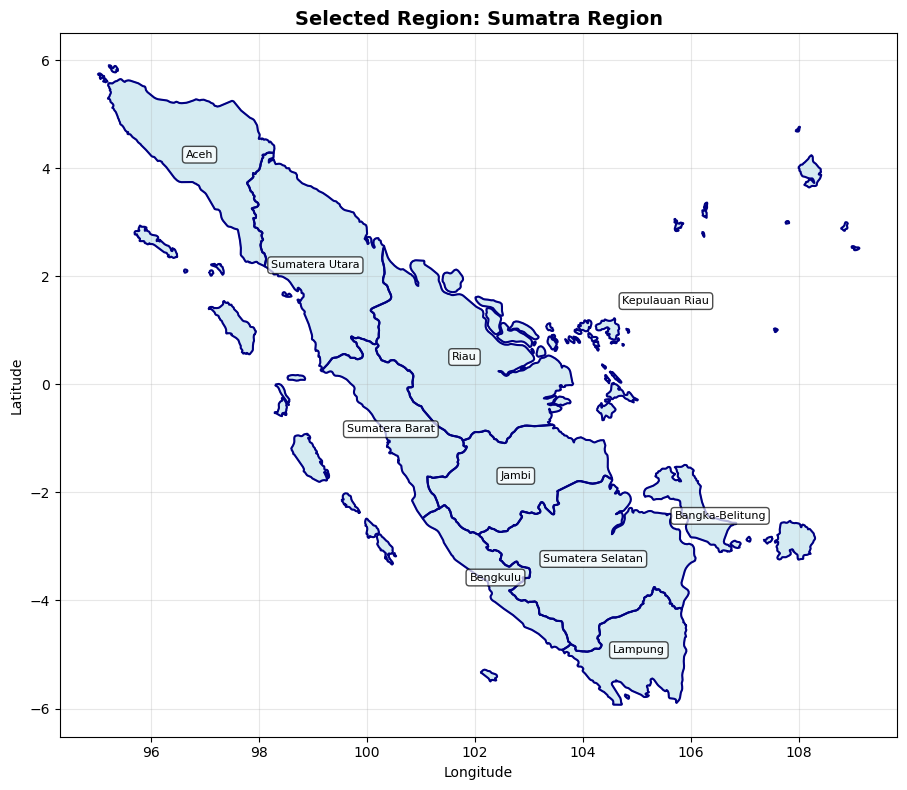

✅ Visualized 10 provinces


In [13]:
# Visualize the selected region
fig, ax = plt.subplots(figsize=(12, 8))
downloader.boundaries.plot(ax=ax, edgecolor='blue', facecolor='lightblue', alpha=0.5)
downloader.boundaries.boundary.plot(ax=ax, edgecolor='navy', linewidth=1.5)

# Add province labels
for idx, row in downloader.boundaries.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['name'], 
            fontsize=8, ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

ax.set_title(f"Selected Region: {downloader.region_info['name']}", fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✅ Visualized {len(downloader.boundaries)} provinces")

## 📥 Step 3: Download Ookla Data

Download connectivity data from Ookla's S3 bucket for your selected region.

In [14]:
# ============================================================================
# CONFIGURATION: Select download parameters
# ============================================================================

# Year and Quarter
YEAR = 2024
QUARTERS = [1]  # List of quarters to download [1, 2, 3, 4]

# Data types
DATA_TYPES = ['mobile']  # Options: 'mobile', 'fixed', or both

print(f"✅ Download Configuration:")
print(f"   Year:     {YEAR}")
print(f"   Quarters: {QUARTERS}")
print(f"   Types:    {DATA_TYPES}")

✅ Download Configuration:
   Year:     2024
   Quarters: [1]
   Types:    ['mobile']


In [ ]:
# Download data for all specified periods
print("Starting download...")
print("="*70)
print("⏳ This may take several minutes depending on region size and quarters selected")
print("="*70)

downloaded_data = downloader.download_multiple(YEAR, QUARTERS, DATA_TYPES)

print(f"\n{'='*70}")
print(f"✅ DOWNLOAD COMPLETE!")
print(f"{'='*70}")
print(f"Downloaded {len(downloaded_data)} dataset(s):")
for key in downloaded_data.keys():
    print(f"  • {key}")
print(f"{'='*70}")

Starting download...
⏳ This may take several minutes depending on region size and quarters selected

Downloading: 2024_Q1_mobile

DOWNLOADING OOKLA DATA
Region:   Sumatra Region
Period:   2024 Q1
Type:     mobile

📥 Downloading from S3...
   s3://ookla-open-data/parquet/performance/type=mobile/year=2024/quarter=1/
   ✅ Downloaded 3,674,000 global tiles

🗺️  Converting to geographic data...

🎯 Filtering to region boundaries...
   Bounding box filter: 77,894 tiles
   Performing precise spatial join...
   ✅ Filtered to 36,960 tiles in region

💾 Saved to: sumatra_region_2024_Q1_mobile_20251113.geoparquet

📊 Summary Statistics:
   Total tiles: 36,960
   Provinces covered: 10
   Avg download speed: 33.55 Mbps
   Avg upload speed: 16.54 Mbps
   Total tests: 250,276

✅ Download complete!

✅ Downloaded 1 datasets

✅ DOWNLOAD COMPLETE!
Downloaded 1 dataset(s):
  • 2024_Q1_mobile


In [16]:
# List all downloaded files
downloader.list_downloaded_files()


Downloaded Ookla Files (4):
  • Sumatra_region_ookla_2019-2025_qall_fixed.geoparquet (  37.2 MB)
  • Sumatra_region_ookla_2019-2025_qall_mobile.geoparquet (  67.8 MB)
  • indonesia_ookla_data_20251006_200803.geoparquet    ( 425.8 MB)
  • sumatra_region_2024_Q1_mobile_20251113.geoparquet  (   2.3 MB)


[PosixPath('/Users/enochtham/Library/CloudStorage/OneDrive-UniversityofOklahoma/VSC - OU/Ookla_final/data/raw/ookla/Sumatra_region_ookla_2019-2025_qall_fixed.geoparquet'),
 PosixPath('/Users/enochtham/Library/CloudStorage/OneDrive-UniversityofOklahoma/VSC - OU/Ookla_final/data/raw/ookla/Sumatra_region_ookla_2019-2025_qall_mobile.geoparquet'),
 PosixPath('/Users/enochtham/Library/CloudStorage/OneDrive-UniversityofOklahoma/VSC - OU/Ookla_final/data/raw/ookla/indonesia_ookla_data_20251006_200803.geoparquet'),
 PosixPath('/Users/enochtham/Library/CloudStorage/OneDrive-UniversityofOklahoma/VSC - OU/Ookla_final/data/raw/ookla/sumatra_region_2024_Q1_mobile_20251113.geoparquet')]

## 📊 Step 4: Prepare Data for Tableau

Select which files to process and convert them to Excel format.

**Default behavior:** Each geoparquet file is converted to its own Excel file, preserving data separation.

**Options:**
- Process all files or select specific ones
- Keep files separate (recommended) or combine them

In [17]:
# Find all downloaded files to prepare
all_ookla_files = list(OOKLA_DIR.glob('*.geoparquet'))

if not all_ookla_files:
    print("❌ No Ookla data files found!")
    print(f"   Please run Step 3 to download data first.")
else:
    print(f"Found {len(all_ookla_files)} file(s) available:\n")
    for idx, f in enumerate(all_ookla_files, 1):
        size_mb = f.stat().st_size / (1024 * 1024)
        print(f"   [{idx}] {f.name} ({size_mb:.1f} MB)")
    
    print(f"\n{'─'*70}")
    print("💡 TIP: You can select specific files to process in the next cell")
    print(f"{'─'*70}")

Found 4 file(s) available:

   [1] Sumatra_region_ookla_2019-2025_qall_mobile.geoparquet (67.8 MB)
   [2] sumatra_region_2024_Q1_mobile_20251113.geoparquet (2.3 MB)
   [3] indonesia_ookla_data_20251006_200803.geoparquet (425.8 MB)
   [4] Sumatra_region_ookla_2019-2025_qall_fixed.geoparquet (37.2 MB)

──────────────────────────────────────────────────────────────────────
💡 TIP: You can select specific files to process in the next cell
──────────────────────────────────────────────────────────────────────


In [18]:
# ============================================================================
# CONFIGURATION: Select files to process
# ============================================================================

# Option 1: Process ALL files (default)
#ookla_files = all_ookla_files

# Option 2: Select specific files by index (uncomment to use)
# Example: Process files 1 and 3
selected_indices = [2]  # Change these numbers based on the list above
ookla_files = [all_ookla_files[i-1] for i in selected_indices]

# Option 3: Select files by pattern (uncomment to use)
# Example: Only mobile files
# ookla_files = [f for f in all_ookla_files if 'mobile' in f.name]

# Option 4: Select files by name (uncomment to use)
# Example: Specific file names
# ookla_files = [f for f in all_ookla_files if f.name in [
#     'sumatra_region_2024_Q1_mobile_20251113.geoparquet',
#     'sumatra_region_2024_Q2_mobile_20251113.geoparquet'
# ]]

print(f"✅ Selected {len(ookla_files)} file(s) to process:")
for f in ookla_files:
    print(f"   • {f.name}")

✅ Selected 1 file(s) to process:
   • sumatra_region_2024_Q1_mobile_20251113.geoparquet


In [19]:
# ============================================================================
# CONFIGURATION: Processing mode
# ============================================================================

# Option 1: Keep files SEPARATE (default - recommended)
# Each geoparquet file creates its own Excel file
COMBINE_FILES = False

# Option 2: COMBINE all files into one Excel
# All selected files merged into a single Excel file
# COMBINE_FILES = True

print(f"📦 Processing Mode: {'COMBINED' if COMBINE_FILES else 'INDIVIDUAL'}")
print(f"{'─'*70}\n")

# Prepare Tableau-ready Excel files
preparer = TableauDataPreparer()

# Prepare all files
output_files = preparer.prepare_from_files(ookla_files, combine=COMBINE_FILES)

print(f"\n🎨 Next steps:")
print(f"   1. Open Tableau Desktop")
print(f"   2. Connect to Excel data source")
print(f"   3. Navigate to: {OUTPUT_DIR}")
print(f"   4. Select any of the generated Excel files")
print(f"\n💡 TIP: Each Excel file maintains the same structure as its source geoparquet")
print(f"{'='*70}")

2025-11-13 21:40:20,051 - INFO - TableauDataPreparer initialized
2025-11-13 21:40:20,052 - INFO - Output directory: /Users/enochtham/Library/CloudStorage/OneDrive-UniversityofOklahoma/VSC - OU/Ookla_final/data/output
2025-11-13 21:40:20,052 - INFO - Loading: sumatra_region_2024_Q1_mobile_20251113.geoparquet
2025-11-13 21:40:20,102 - INFO - ✅ Aggregated to 36,960 bins
2025-11-13 21:40:20,103 - INFO -    Compression: 36,960 → 36,960 (100.0%)


📦 Processing Mode: INDIVIDUAL
──────────────────────────────────────────────────────────────────────


PREPARING OOKLA DATA FOR TABLEAU

📦 Mode: INDIVIDUAL - Each file gets its own Excel
   Processing 1 file(s)...


──────────────────────────────────────────────────────────────────────
Processing: sumatra_region_2024_Q1_mobile_20251113.geoparquet
──────────────────────────────────────────────────────────────────────
   Records: 36,960

📦 Aggregating data to bins...


2025-11-13 21:40:24,921 - INFO -    Sheet 'Data': 36,960 rows


   ✅ Created: sumatra_region_2024_Q1_mobile_20251113.xlsx

✅ TABLEAU FILES READY!
Created 1 Excel file(s) in: /Users/enochtham/Library/CloudStorage/OneDrive-UniversityofOklahoma/VSC - OU/Ookla_final/data/output

📁 Output files:
   • sumatra_region_2024_Q1_mobile_20251113.xlsx (3.1 MB)


🎨 Next steps:
   1. Open Tableau Desktop
   2. Connect to Excel data source
   3. Navigate to: /Users/enochtham/Library/CloudStorage/OneDrive-UniversityofOklahoma/VSC - OU/Ookla_final/data/output
   4. Select any of the generated Excel files

💡 TIP: Each Excel file maintains the same structure as its source geoparquet


## 📈 Optional: Preview Data

Quick preview of the downloaded connectivity data.

In [20]:
# Load and preview one of the downloaded datasets
if ookla_files:
    sample_file = ookla_files[0]
    print(f"Loading sample data: {sample_file.name}")
    
    sample_data = pd.read_parquet(sample_file)
    
    print(f"\n📊 Dataset Preview:")
    print(f"   Total records: {len(sample_data):,}")
    print(f"   Columns: {len(sample_data.columns)}")
    print(f"\n   First 5 rows:")
    display(sample_data.head())
    
    print(f"\n📈 Basic Statistics:")
    if 'avg_d_mbps' in sample_data.columns:
        print(f"   Download Speed (Mbps):")
        print(f"      Mean:   {sample_data['avg_d_mbps'].mean():.2f}")
        print(f"      Median: {sample_data['avg_d_mbps'].median():.2f}")
        print(f"      Min:    {sample_data['avg_d_mbps'].min():.2f}")
        print(f"      Max:    {sample_data['avg_d_mbps'].max():.2f}")
    
    if 'avg_u_mbps' in sample_data.columns:
        print(f"   Upload Speed (Mbps):")
        print(f"      Mean:   {sample_data['avg_u_mbps'].mean():.2f}")
        print(f"      Median: {sample_data['avg_u_mbps'].median():.2f}")
        print(f"      Min:    {sample_data['avg_u_mbps'].min():.2f}")
        print(f"      Max:    {sample_data['avg_u_mbps'].max():.2f}")
else:
    print("No data files available for preview.")

Loading sample data: sumatra_region_2024_Q1_mobile_20251113.geoparquet

📊 Dataset Preview:
   Total records: 36,960
   Columns: 15

   First 5 rows:


,devices,quadkey,avg_d_kbps,tile,avg_lat_ms,avg_u_kbps,name,tests,year,quarter,data_type,region,country,avg_d_mbps,avg_u_mbps
0,1,1322203332112123,27667,"POLYGON((95.2130126953125 5.90565283255787, 95...",16,29624,Aceh,2,2024,1,mobile,Sumatra Region,Indonesia,27.667,29.624
1,1,1322203332113323,77825,"POLYGON((95.2569580078125 5.88379636175571, 95...",109,34192,Aceh,1,2024,1,mobile,Sumatra Region,Indonesia,77.825,34.192
2,6,1322203332131100,38402,"POLYGON((95.25146484375 5.87833210967432, 95.2...",79,14538,Aceh,8,2024,1,mobile,Sumatra Region,Indonesia,38.402,14.538
3,3,1322203332131102,29269,"POLYGON((95.25146484375 5.87286780393893, 95.2...",68,10636,Aceh,3,2024,1,mobile,Sumatra Region,Indonesia,29.269,10.636
4,1,1322203332131103,3923,"POLYGON((95.2569580078125 5.87286780393893, 95...",211,5746,Aceh,1,2024,1,mobile,Sumatra Region,Indonesia,3.923,5.746



📈 Basic Statistics:
   Download Speed (Mbps):
      Mean:   33.55
      Median: 26.60
      Min:    0.00
      Max:    357.88
   Upload Speed (Mbps):
      Mean:   16.54
      Median: 14.50
      Min:    0.00
      Max:    80.59


---

## 🎯 Summary

This notebook provides a complete workflow for:
- ✅ Loading geographic boundaries from Natural Earth
- ✅ Downloading Ookla connectivity data from S3
- ✅ Filtering data to your specified region
- ✅ Preparing Excel files for Tableau (each file kept separate)

### Quick Reference

**To analyze a different region:**
1. Change `SELECTED_REGION` in Step 2
2. Re-run cells from Step 2 onwards

**To download different time periods:**
1. Modify `YEAR` and `QUARTERS` in Step 3
2. Re-run Step 3 and Step 4

**To process specific files:**
1. In Step 4, uncomment and modify one of the file selection options
2. Choose between separate or combined Excel output

**To add new regions:**
1. Edit `src/config.py`
2. Add entry to `REGION_PRESETS` dictionary
3. Re-run first cell to reload config

### Output Files

- **Raw Data**: `data/raw/ookla/*.geoparquet` (one per quarter/type)
- **Tableau Files**: `data/output/*.xlsx` (one per geoparquet by default)

### File Processing Modes

**Individual (Default):** Each geoparquet → separate Excel
- ✅ Preserves data separation
- ✅ Easier to manage in Tableau
- ✅ Better performance

**Combined:** All geoparquet → single Excel
- Use when comparing across all periods
- Larger file size

---

**Need help?** Check the README.md in the project root.